<a href="https://colab.research.google.com/github/EgorDudyrev/paspailleur/blob/main/Ngrams_from_IJCAI23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the latest version of `paspailleur` from Git (it will soon be published on PyPi)

In [1]:
!git clone https://github.com/EgorDudyrev/paspailleur.git
!pip install paspailleur/. --quiet

Cloning into 'paspailleur'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 323 (delta 204), reused 252 (delta 154), pack-reused 0
Receiving objects: 100% (323/323), 197.24 KiB | 3.87 MiB/s, done.
Resolving deltas: 100% (204/204), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 571.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


* `caspailleur` is a package to work with binary FCA
* `paspailleur` is an extension of `caspailleur` to the realm of complex data (including ngrams)

In [2]:
import caspailleur as csp
from paspailleur.pattern_structures import NgramPS

/usr/local/lib/python3.10/dist-packages/paspailleur/pattern_structures/abstract_ps.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Import some general use packages

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.notebook import tqdm

# Load data

In [4]:
url = "https://ijcai-23.org/paper-schedule/"
page = requests.get(url)

In [5]:
def parse_paper_entry(paper_data):
    paper_dict = dict(
        title = paper_data.find('div', class_='p_title').text,
        authors = paper_data.find('div', class_='p_authors').text.split(';'),
        abstract = paper_data.find('div', class_='p_abstract').text,
    )
    return paper_dict

soup = BeautifulSoup(page.content, "html.parser")
papers_data = soup.find_all("div", class_="paper_entry")

In [6]:
df = pd.DataFrame([parse_paper_entry(paper_data) for paper_data in soup.find_all('div', class_='paper_entry')])
print(df.shape)
df.head()

(711, 3)


,title,authors,abstract
0,From Association to Generation: Text-only Capt...,"[Junyang Wang, Ming Yan, Yi Zhang, Jitao Sang]",With the development of Vision-Language Pre-tr...
1,Graph-based Molecular Representation Learning,"[Zhichun Guo, Kehan Guo, Bozhao Nan, Yijun ...",Molecular representation learning (MRL) is a k...
2,Recognizable Information Bottleneck,"[Yilin Lyu, Xin Liu, Mingyang Song, Xinyue ...",Information Bottlenecks (IBs) learn representa...
3,ReLiNet: Stable and Explainable Multistep Pred...,"[Alexandra Baier, Decky Aspandi, Steffen Staab]",Multistep prediction models are essential for ...
4,Some Might Say All You Need Is Sum,"[Eran Rosenbluth, Jan Tönshoff, Martin Grohe]",The expressivity of Graph Neural Networks (GNN...


# Find the stable patterns

Some basic preprocessing of the data. For example, we surround the dot "." with spaces to make it considered as a distinct word (1ngram).

In [7]:
texts = df['abstract'].fillna('').tolist()
texts = [txt.lower().replace(':', ' ').replace('.', ' . ').replace(',',' , ').replace('(', ' ( ').replace(')', ' ) ') for txt in texts]
texts = [re.sub(r'\s+', ' ', txt).strip() for txt in texts]

Create the NgramPS object and convert the `texts` into `patterns` so that `ps` would be able to work with them

In [8]:
ps = NgramPS()
patterns = list(ps.preprocess_data(texts))
print(patterns[:5])

[frozenset({('with', 'the', 'development', 'of', 'vision-language', 'pre-training', 'models', '(', 'vlpms', ')', 'represented', 'by', 'clip', 'and', 'align', ',', 'significant', 'breakthroughs', 'have', 'been', 'achieved', 'for', 'association-based', 'visual', 'tasks', 'such', 'as', 'image', 'classification', 'and', 'image-text', 'retrieval', 'by', 'the', 'zero-shot', 'capability', 'of', 'clip', 'without', 'fine-tuning', '.', 'however', ',', 'clip', 'is', 'hard', 'to', 'apply', 'to', 'generation-based', 'tasks', '.', 'this', 'is', 'due', 'to', 'the', 'lack', 'of', 'decoder', 'architecture', 'and', 'pre-training', 'tasks', 'for', 'generation', '.', 'although', 'previous', 'works', 'have', 'created', 'generation', 'capacity', 'for', 'clip', 'through', 'additional', 'language', 'models', ',', 'a', 'modality', 'gap', 'between', 'the', 'clip', 'representations', 'of', 'different', 'modalities', 'and', 'the', 'inability', 'of', 'clip', 'to', 'model', 'the', 'offset', 'of', 'this', 'gap', ','

Let us count the number of ngrams we can derive from `patterns`

In [9]:
%%time
n_bin_attrs = ps.n_bin_attributes(patterns, min_support=0.01, use_tqdm=True)
print(n_bin_attrs)

Counting patterns: 0it [00:00, ?it/s]

6002
CPU times: user 2min 51s, sys: 699 ms, total: 2min 52s
Wall time: 3min 7s


"6002" looks like a manageable amount of ngrams (20k or 100k would be too much). So we can just put them into Sofia algorithm from `caspailleur`

In [10]:
%%time
# Initial, unfiltered set of ngrams (and their extents) that we'd like to study
extents_iterator = [extent for ngram, extent in tqdm(ps.iter_bin_attributes(patterns, min_support=0.01), total=n_bin_attrs)]

  0%|          | 0/6002 [00:00<?, ?it/s]

CPU times: user 2min 49s, sys: 764 ms, total: 2min 50s
Wall time: 2min 53s


**Edit:** Actually, after the first analysis, I have found many ngrams that are very frequent and stable but of little to no interest. For example, 1gram "and" lies in almost every text but is not interesting to for our analysis.

One can use the list of stopgrams from `nltk`. However, manually constructed set of stop words gives more versatility. Specifically, it does not exclude the word "we" from the analysis (which is an important pattern, when applied to the scientific writing).

In [11]:
%%time
# A set of stopwords, constructed after studying the stable concepts obtained without stopwords
STOP_WORDS = {
    'which', 'for', 'more', 'both', 'well', 'the', 'at', 'and', 'also', 'each', 'using', ',',
    'in', 'have', 'by', 'three', 'a', 'this', '(', 'such', 'that', 'from', 'with', 'two', '.',
    'it', 'into', 'new', 'of', 'as', 'through', 'to', 'these', 'over', '.', 'an', 'than', 'are', 'can',
    'is', 'most', 'where', 'only', 'our', ')', 'between', 'via', 'used', 'when', 'on', 'not', 'their',
    'be', 'often', 'while', 'or', 'its', 'has', 'been'
}
# Filtering ngrams, as some of them may be stable and frequent but useless (e.g. all the prepositions)
extents_iterator = [extent for ngram, extent in tqdm(ps.iter_bin_attributes(patterns, min_support=0.01), total=n_bin_attrs)
                    if any(word not in STOP_WORDS for word in ngram)]

  0%|          | 0/6002 [00:00<?, ?it/s]

CPU times: user 2min 52s, sys: 825 ms, total: 2min 53s
Wall time: 2min 56s


Now, let us run Sofia algorithm from `caspailleur` that takes ngram extents as input and outputs 'stable' extents: each is an intersection of some of the input extents.

*Extent* is a term from Formal Concept Analysis denoting the set of objects described by some pattern (in our case, the set of texts described by some ngrams).

In [12]:
%%time
extents = csp.mine_equivalence_classes.list_stable_extents_via_sofia(
    extents_iterator,
    n_stable_extents=1_000, min_supp=int(len(patterns)*0.01),
    use_tqdm=True
)
print(len(extents))

100%|██████████| 5366/5366 [06:22<00:00, 14.04it/s]

985
CPU times: user 6min 13s, sys: 1.96 s, total: 6min 15s
Wall time: 6min 22s


The top extent that covers all the objects may not be among the stable extents. But it is still interesting to us as it represents the most general ngram.

In [13]:
if not any(ext.all() for ext in extents):
    an_extent = list(extents)[0]
    full_extent = an_extent | ~an_extent
    extents.add(full_extent)

Now, we order the extents from the most general ones to the most specific. And we compute their intents.

*Intent* is an FCA term representing the maximal description of the extent. In our case, intent is a set of maximal ngrams found in all the texts from the extent.

In [14]:
%%time
extents = csp.order.topological_sorting(extents)[0][::-1]
intents = [ps.intent(patterns, extent.itersearch(True)) for extent in tqdm(extents)]

  0%|          | 0/985 [00:00<?, ?it/s]

CPU times: user 31 s, sys: 190 ms, total: 31.2 s
Wall time: 34.6 s


In [15]:
assert len(set(extents)) == len(set(intents)) == len(intents)

Let us put all the found intents into a pandas DataFrame. So that it will be easier for us to find the most interesting ngrams.

We consider an ngram _(actually, a set of maximal ngrams, shared by the same extent)_ interesting if it has high *delta stability*, has high *support* and does not consists solely from the stop words:

* *Support* measures the number of texts containing a given ngram.
* *Delta stability* shows the minimal support an ngram will loose if any other word would be added to this ngram.

In [16]:
def form_patterns_df(extents, intents_verb, stop_words):
    delta_stability = list(csp.indices.delta_stability_index(extents[::-1]))[::-1]
    intents_verb_nonstop = [
        frozenset({ngram for ngram in intent
                   if any(word not in stop_words for word in ngram.split(' '))})
        for intent in intents_verb]
    stop_wordish = [set() < intent <= stop_words for intent in intents_verb]

    pat_df = pd.DataFrame()
    pat_df['pattern'] = intents_verb
    pat_df['pattern_nonstop'] = intents_verb_nonstop
    pat_df['delta_stability'] = delta_stability
    pat_df['no_stopwords'] = [not x for x in stop_wordish]
    pat_df['support'] = [ext.count() for ext in extents]

    pat_df['first_nonstop_appearance'] = False
    pat_df.loc[pat_df.reset_index().groupby('pattern_nonstop')['index'].min().values, 'first_nonstop_appearance'] = True
    assert pat_df['first_nonstop_appearance'].sum() == pat_df['pattern_nonstop'].nunique()

    pat_df['interestingness'] = pat_df[['delta_stability', 'first_nonstop_appearance', 'support']].product(1)
    pat_df = pat_df.sort_values('interestingness', ascending=False)
    return pat_df

In [17]:
intents_verb = [{' '.join(ngram) for ngram in intent} for intent in intents]
patterns_df = form_patterns_df(extents, intents_verb, STOP_WORDS)
print(patterns_df.shape)
patterns_df[['pattern_nonstop', 'interestingness', 'support', 'delta_stability', 'pattern']].iloc[:50]

(985, 7)


,pattern_nonstop,interestingness,support,delta_stability,pattern
2,"(, we)",142186.0,562,253,"{, we, .}"
1,(we),56463.0,649,87,"{we, .}"
10,"(. we, , we)",45080.0,280,161,"{. we, , we}"
0,(),44082.0,711,62,{}
14,"(, we, model)",32250.0,250,129,"{, we, to, model, .}"
13,"(, we, learning)",31878.0,253,126,"{., the, to, , we, learning}"
3,(. we),27056.0,356,76,{. we}
18,"(, we, methods)",22700.0,227,100,"{., the, to, , we, methods}"
20,"(, we, results)",21930.0,215,102,"{, we, the, ., results}"
16,"(, we propose)",21120.0,240,88,"{to, , we propose, .}"


Above is the table of the most interesting  ngrams in the data. But it would be nice to somehow visuale them.

# Visualize the best concepts

Traditionally, in FCA, we use the line diagrams (aka Hasse diagrams) to visualize the set of intents.

**Note** `Caspailleur` and `paspailleur` are not intended to make visualizations. So we will have to write a lot of code.

First, we select 30 the most interesting patterns. Because a like diagram with even 50 patterns becomes unreadable.

In [18]:
n_best = 30
best_idxs = patterns_df.index[:n_best].tolist()
best_extents = [extents[i] for i in best_idxs]

if not any(ext.all() for ext in best_extents):
    best_extents.append(best_extents[0] | (~best_extents[0]))
if not any(not ext.any() for ext in best_extents):
    best_extents.append(best_extents[0] & (~best_extents[0]))

best_extents = csp.order.topological_sorting(best_extents)[0][::-1]
best_intents_verb = [{' '.join(ngram) for ngram in ps.intent(patterns, extent.itersearch(True))} for extent in best_extents]

Find the generality order between patterns

In [19]:
parents_ordering = csp.sort_intents_inclusion(best_extents[::-1])
parents_ordering = [parents[::-1] for parents in parents_ordering[::-1]]

children_ordering = csp.inverse_order(parents_ordering)

Create human readable labels for nodes in the diagram

In [20]:
node_patterns = []
node_patterns_verb = []
for intent, parents_ba in zip(best_intents_verb[:-1], parents_ordering):
    if not parents_ba.any():  # Top node label
        node_patterns_verb.append("Ngrams in Abstract of IJCAI'23 Papers")
        node_patterns.append({node_patterns_verb[-1]})
        continue

    label = {ngram for ngram in intent if any(word not in STOP_WORDS for word in ngram.split(' '))}
    node_patterns.append(label)
    label = '\n'.join(sorted(label, key=lambda ngram_str: len(ngram_str)))
    node_patterns_verb.append(label)

node_labels = [label + f"\n\nsupp: {extent.count()}" for label, extent in zip(node_patterns_verb, best_extents)]

Find the levels of node, i.e. fix the Y-coordinate of patterns on a diagram.

In [21]:
node_levels = []
for parents_ba in parents_ordering:
    node_level = max(node_levels[parent] for parent in parents_ba.itersearch(True))+1 if parents_ba.any() else 0
    node_levels.append(node_level)

Create the `networkx` graph to represent the best intents, ordered by their generality.

In [22]:
import networkx as nx

graph = nx.DiGraph()
graph.add_nodes_from(range(len(best_extents)))
graph.add_edges_from(
    [(parent, child) for parent, children in enumerate(children_ordering)
    for child in children.itersearch(True)]
)

graph.remove_node(len(best_extents)-1)  # bottom node

for node in graph.nodes:
    graph.nodes[node]['level'] = node_levels[node]

Specify the positions of nodes (use some built-in functions from `networkx` plus manual adjustments)

In [23]:
pos = nx.drawing.layout.multipartite_layout(graph, subset_key='level')
pos = {k: [y, -x] for k, (x, y) in pos.items()}

# Manually update the positions of nodes to make them look better

for node_a, node_b in [
    (', we\ndifferent', ', we\nlearning'),
    (', we\npropose', ', we\n. we'),
    (', we\nthis paper', 'data\n, we'),
]:
    node_a, node_b = [node_patterns.index(set(node.split('\n'))) for node in [node_a, node_b]]
    pos[node_a], pos[node_b] = pos[node_b], pos[node_a]

for node_move, node_fix in [
    ('. we', ', we\n. we'),
    ('learning', ', we\nlearning'),
    (', we propose', ', we\npropose'),
    ('. in this paper , we', ', we\nthis paper'),
    ('this paper', ', we\nthis paper'),
    ('we', node_patterns_verb[0]),
    (', we', 'we'),
]:
  node_move, node_fix = [node_patterns.index(set(node.split('\n'))) for node in [node_move, node_fix]]
  pos[node_move][0] = pos[node_fix][0]


# Jitter nodes withing one level
same_level_nodes = [node for node in graph.nodes if node_levels[node] == 3]
same_level_nodes = sorted(same_level_nodes, key=lambda node: pos[node][0])
for i, node in enumerate(same_level_nodes):
    pos[node][1] += (i%2)*0.03

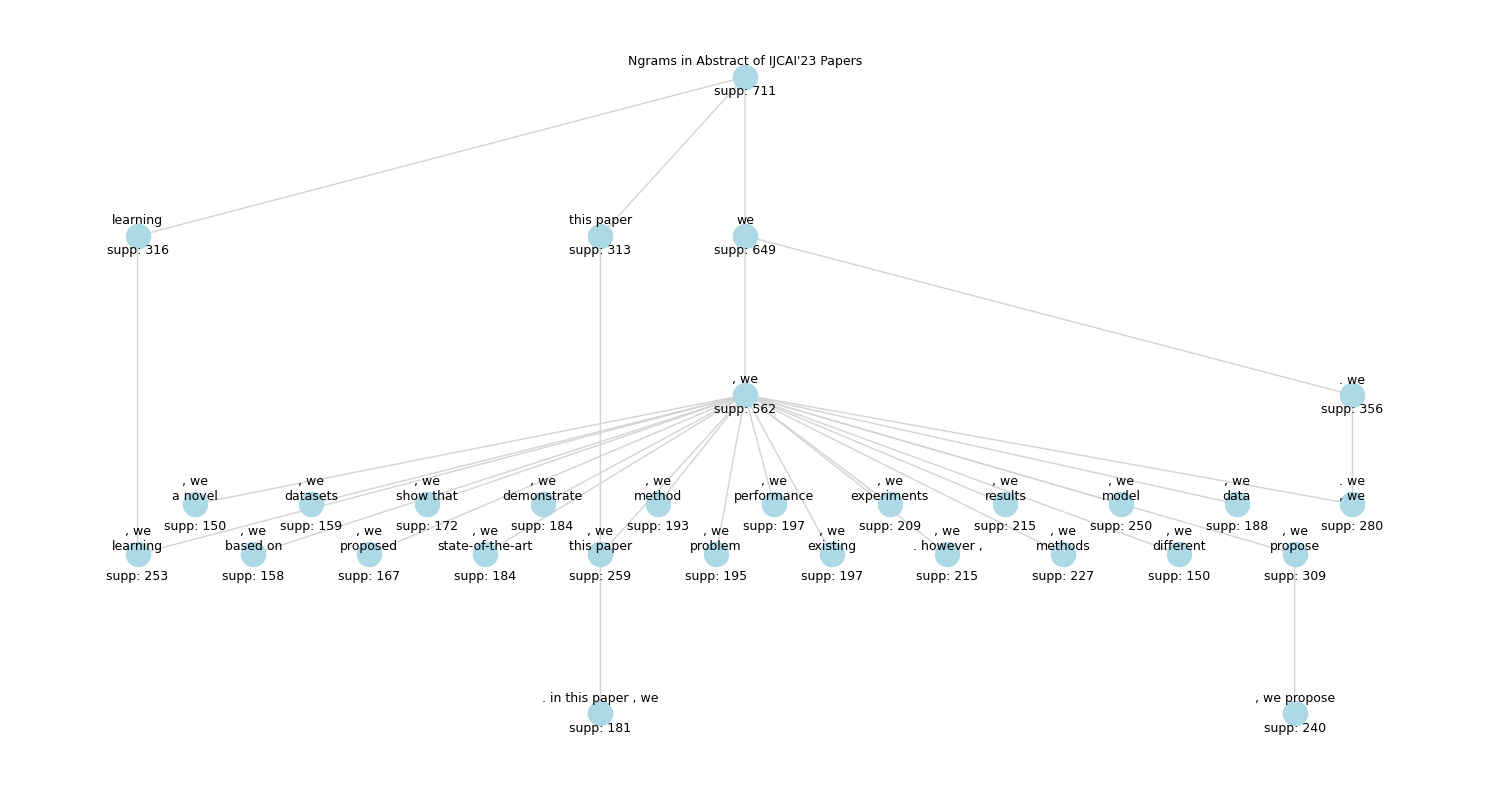

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))

nx.draw_networkx_edges(graph, pos=pos, ax=ax, edge_color='lightgray', arrowstyle='-')
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, alpha=1, node_color='lightblue')
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels={node: node_labels[node] for node in graph.nodes}, font_size=9)

plt.box(False)

plt.tight_layout()
plt.savefig('stable_IJCAI23_abstracts.pdf')
plt.show()

Line diagram can show us the order between ngrams and intents. But it cannot visualize all the stable intents. Aditionally, many ngrams seems to be incomparable.

# Put the results in a wordcloud

Frequent ngrams are often visualized with Word Clouds. So we can make them into a Ngram Cloud.

First, select all the patterns

In [25]:
n_best = 1000
best_idxs = patterns_df.index[:n_best].tolist()
best_extents = [extents[i] for i in best_idxs]

best_extents = csp.order.topological_sorting(best_extents)[0][::-1]
best_intents_verb = [{' '.join(ngram) for ngram in ps.intent(patterns, extent.itersearch(True))} for extent in best_extents]

With WordClouds we are not interested in the order among ngrams, but we should know their supports

In [26]:
ngrams_supports_dict = {tuple(ngram.split(' ')): extent.count()
                        for extent, intent_verb in zip(best_extents, best_intents_verb) if extent.any()
                        for ngram in intent_verb if any(word not in STOP_WORDS for word in ngram.split(' '))}

Still, some of the ngrams are comparable. For example "we propose" and "we propose a". So let us visualize only the maximal ngrams.

In [27]:
maximal_ngrams = sorted(ngrams_supports_dict, key=lambda ngram: len(ngram), reverse=True)
for i in range(len(maximal_ngrams)):
    if i >= len(maximal_ngrams) -1:
        continue
    cur_ngram = maximal_ngrams[i]
    maximal_ngrams[i+1:] = [ngram for ngram in maximal_ngrams[i+1:] if not ps.is_less_precise({ngram}, {cur_ngram})]
ngrams_supports_dict = {ngram: ngrams_supports_dict[ngram] for ngram in maximal_ngrams}
print(len(ngrams_supports_dict))

137


`WordCloud` package takes text as input. So we convert the maximal ngrams into the text.

In [28]:
wordcloud_text = '\n'.join([' '.join(['_'.join(ngram)]*support) for ngram, support in ngrams_supports_dict.items()] )
wordcloud_text = wordcloud_text.replace('.', 'DOT').replace(',', 'COMMA').replace('-','_').replace('//','').replace('(', 'LPAR').replace(')', 'RPAR')
wordcloud = WordCloud(width=1600, height=800, collocations=False, stopwords=set(), repeat=False, random_state=42, background_color='white').generate(wordcloud_text)

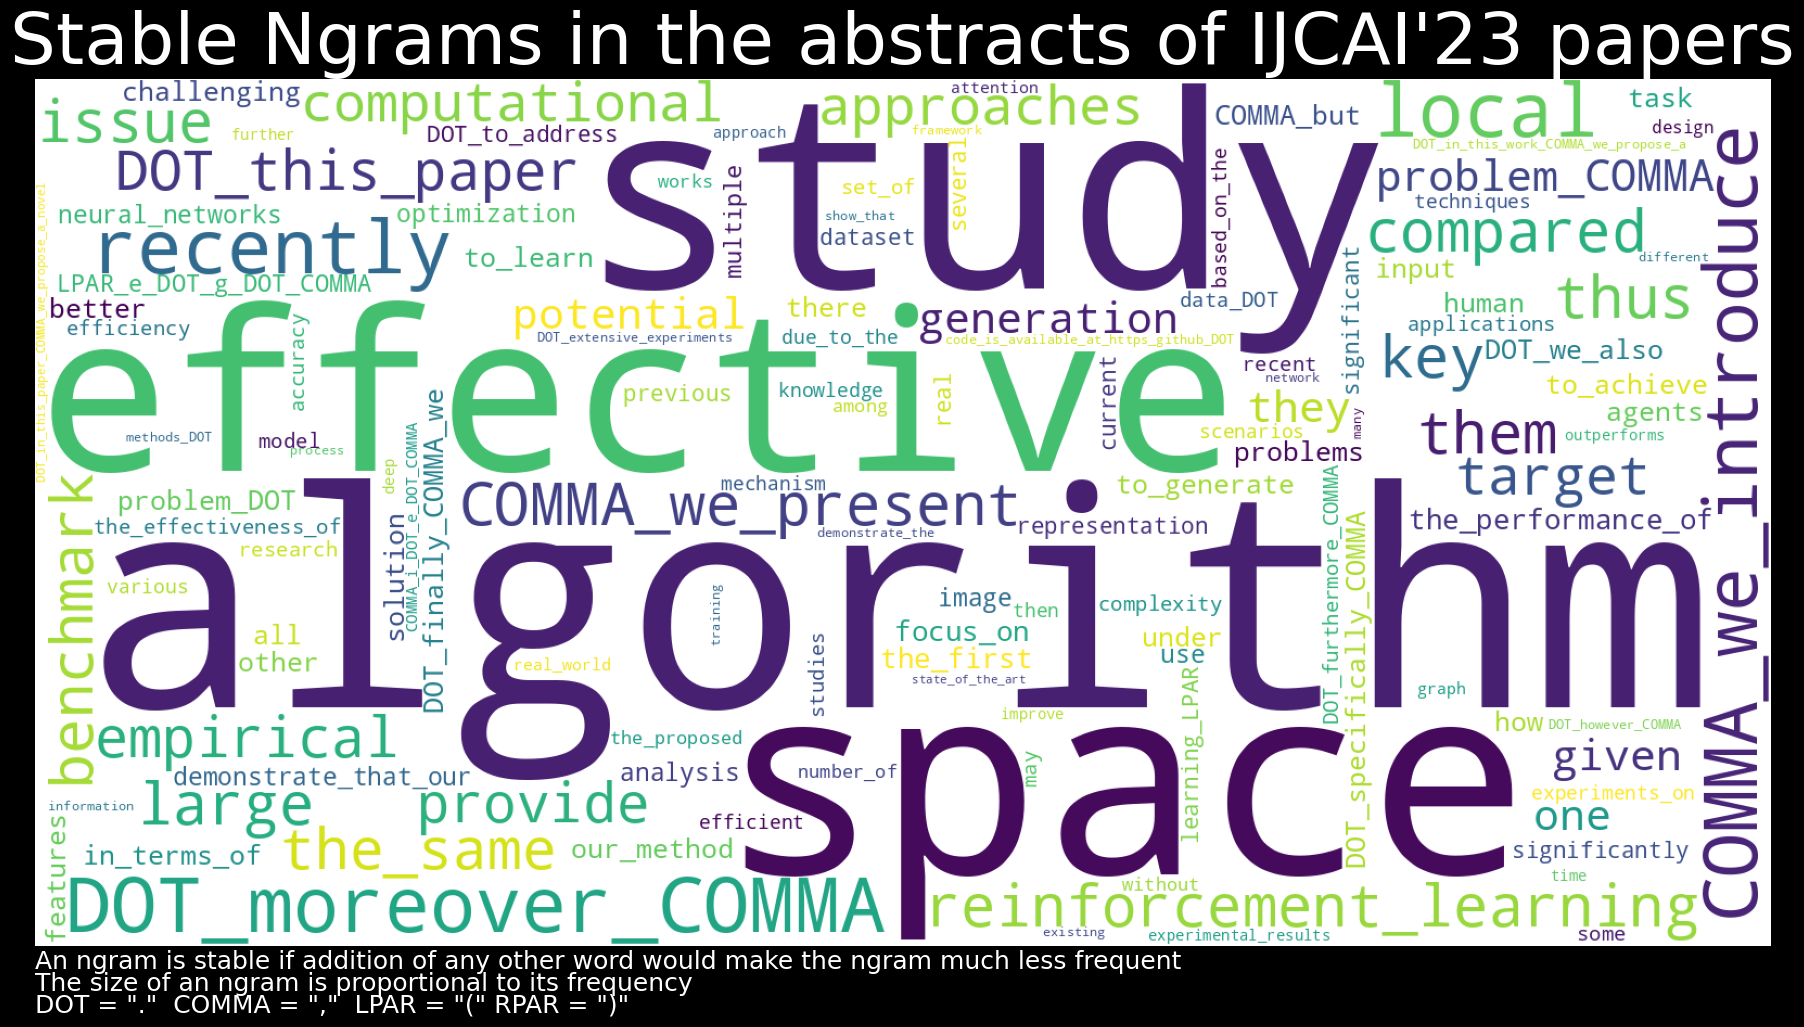

In [29]:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Stable Ngrams in the abstracts of IJCAI'23 papers", size=52, color='white')
plt.text(0, 820, 'An ngram is stable if addition of any other word would make the ngram much less frequent', size=18, color='white')
plt.text(0, 840, 'The size of an ngram is proportional to its frequency', size=18, color='white')
plt.text(0, 860, 'DOT = "."  COMMA = ","  LPAR = "(" RPAR = ")"', size=18, color='white')
plt.tight_layout(pad=0)
plt.savefig('ijcai_abstracts_word.pdf', bbox_inches='tight')

plt.show()

One can say that `WordCloud` can find interesting ngrams on its own. So we do not need a notion of stability and FCA.

However, `WordCloud` works with words (and bigrams). So it can not find stable 3grams, 4grams and so on.
Contrary to that, our approach is not limited by the size of an ngram, as far as it is stable and frequent. For example, this NgramCloud contains a 7gram "code_is_available_at_https_github_DOT" and an 8gram "DOT_in_this_paperCOMMA_we_propose_a_novel". They are shown with small letters, as they are relatively rare, but they are still interesting.